# Importing the libraries

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
cf.go_offline()
%matplotlib inline
import geopandas as gpd
import plotly_express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import datetime
from IPython.display import HTML

# Reading the data

In [96]:
AgeGroup = pd.read_csv('AgeGroupDetails.csv')

In [97]:
df = pd.read_csv('covid_19_india.csv', parse_dates=['Date'], dayfirst=True)

In [98]:
Hospitals = pd.read_csv('HospitalBedsIndia.csv')

In [99]:
Labs = pd.read_csv('ICMRTestingLabs.csv')

In [100]:
Individuals = pd.read_csv('IndividualDetails.csv')

In [101]:
States = pd.read_csv('StatewiseTestingDetails.csv')

# Exploring the data

## Age Group Analysis

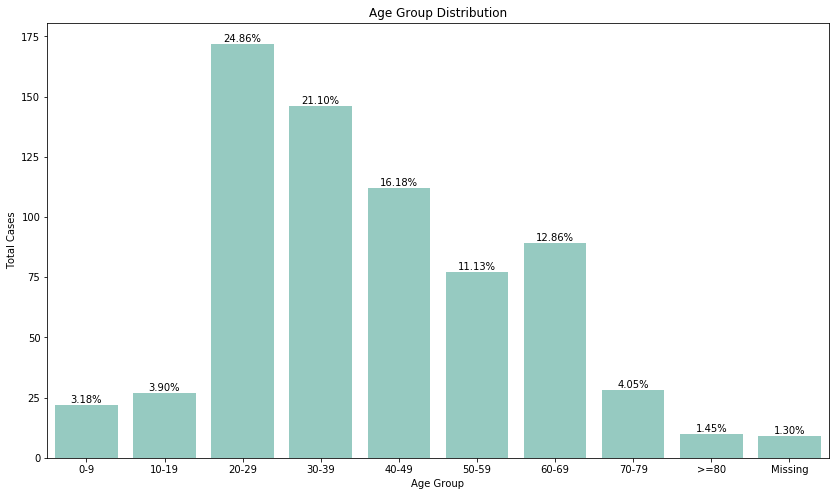

In [74]:
plt.figure(figsize=(14,8))
sns.barplot(data=AgeGroup,x='AgeGroup',y='TotalCases',color=sns.color_palette('Set3')[0])
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Total Cases')
for i in range(AgeGroup.shape[0]):
    count = AgeGroup.iloc[i]['TotalCases']
    plt.text(i,count+1,AgeGroup.iloc[i]['Percentage'],ha='center')
    

### Majority of people affected are in 20-50 age group.

## Gender-wise Analysis

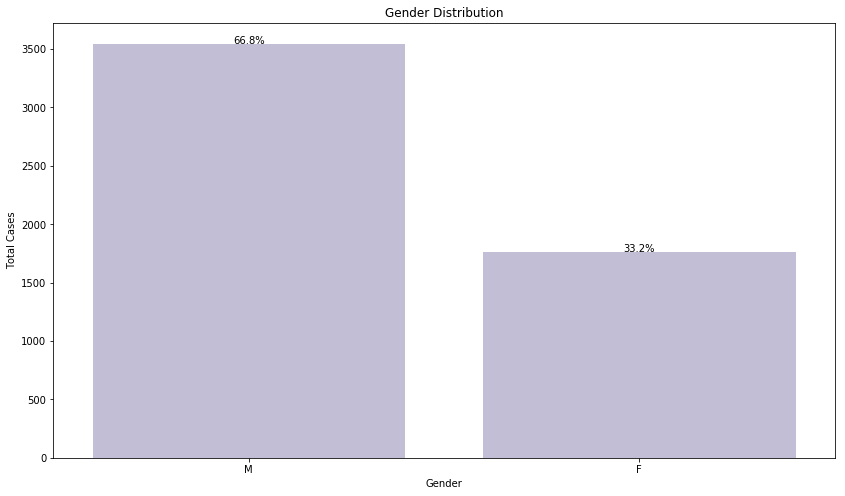

In [75]:
plt.figure(figsize=(14,8))
sns.countplot(data=Individuals,x='gender',order=Individuals['gender'].value_counts().index,color=sns.color_palette('Set3')[2])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Total Cases')
order2 = Individuals['gender'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / Individuals.gender.dropna().count() )
    plt.text(i,count+2,strt,ha='center')

### Corona Virus is more dominant among men.

## Bar Chart Race

In [76]:
%%HTML
<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/2061549" data-url="https://flo.uri.sh/visualisation/2061549/embed"><script src="https://public.flourish.studio/resources/embed.js"></script></div>

## State-wise Breakdown

In [77]:
state_cases = df.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
state_cases['Active'] = state_cases['Confirmed'] - abs((state_cases['Deaths']- state_cases['Cured']))
state_cases["Death Rate (per 100)"] = np.round(100*state_cases["Deaths"]/state_cases["Confirmed"],2)
state_cases["Cure Rate (per 100)"] = np.round(100*state_cases["Cured"]/state_cases["Confirmed"],2)
state_cases.sort_values('Confirmed', ascending= False).fillna(0).style.background_gradient(cmap='Reds',subset=["Confirmed"])\
                        .background_gradient(cmap='Blues',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Cured"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Greys',subset=["Death Rate (per 100)"])\
                        .background_gradient(cmap='Oranges',subset=["Cure Rate (per 100)"])

,State/UnionTerritory,Confirmed,Deaths,Cured,Active,Death Rate (per 100),Cure Rate (per 100)
22,Maharashtra,230599,9667,127259,113007,4.19,55.19
32,Tamil Nadu,126581,1765,78161,50185,1.39,61.75
11,Delhi,107051,3258,82226,28083,3.04,76.81
13,Gujarat,39194,2008,27718,13484,5.12,70.72
37,Uttar Pradesh,32362,862,21127,12097,2.66,65.28
18,Karnataka,31105,486,12833,18758,1.56,41.26
33,Telangana,30946,331,18192,13085,1.07,58.79
39,West Bengal,25911,854,16826,9939,3.3,64.94
1,Andhra Pradesh,23814,277,12154,11937,1.16,51.04
30,Rajasthan,22563,491,17070,5984,2.18,75.65


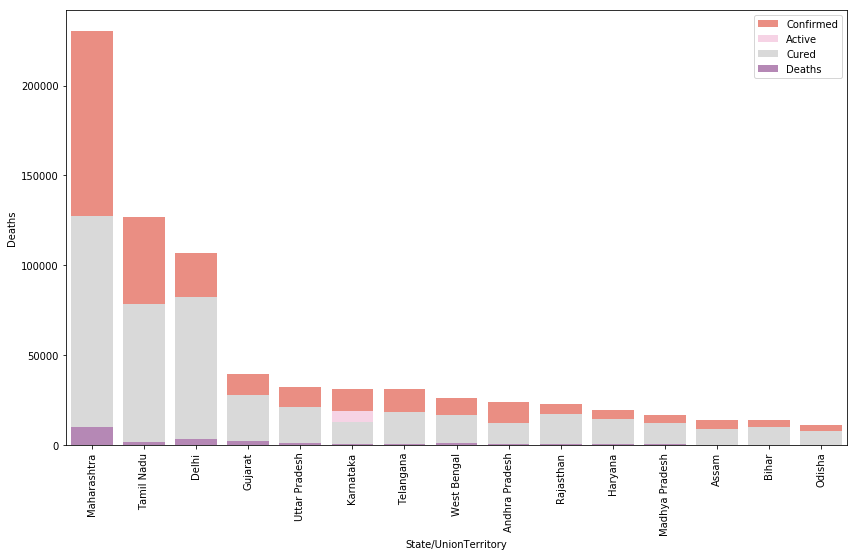

In [102]:
state_cases=state_cases.sort_values('Confirmed', ascending= False).fillna(0)
state_cases=state_cases.head(15)
state_cases
plt.figure(figsize=(14,8))
sns.barplot(data=state_cases,x='State/UnionTerritory',y='Confirmed',color=sns.color_palette('Set3')[3],label='Confirmed')
sns.barplot(data=state_cases,x='State/UnionTerritory',y='Active',color=sns.color_palette('Set3')[7],label='Active')
sns.barplot(data=state_cases,x='State/UnionTerritory',y='Cured',color=sns.color_palette('Set3')[8],label='Cured')
sns.barplot(data=state_cases,x='State/UnionTerritory',y='Deaths',color=sns.color_palette('Set3')[9],label='Deaths')
plt.xticks(rotation=90)
plt.legend();

## Country Breakdown

In [103]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
CS_covid = df[['Date','State/UnionTerritory','Cured','Deaths','Confirmed']]
CS_covid = CS_covid.groupby('Date')[['Confirmed', 'Cured','Deaths']].sum().reset_index()

In [104]:
CS_covid['Active'] = CS_covid['Confirmed'] - CS_covid['Cured'] - CS_covid['Deaths']
CS_covid['new_case/day'] = CS_covid['Confirmed'] - CS_covid['Confirmed'].shift(1)
CS_covid['growth_ratio'] = CS_covid['new_case/day'] / CS_covid['new_case/day'].shift(1)
CS_covid['new_case/day'] = CS_covid['new_case/day'].replace(np.nan,'0.0')
CS_covid['growth_ratio'] = CS_covid['growth_ratio'].replace(np.nan,'0.0')

In [105]:
CS_covid_melt_df = pd.melt(CS_covid, id_vars=['Date'], value_vars=['Confirmed','Active','Cured','new_case/day','Deaths'])

In [106]:
target_date = CS_covid_melt_df['Date'].max()
fig = px.line(CS_covid_melt_df, x="Date", y="value", color='variable', 
              title=f'All-India Cases as of {target_date}')
fig.show()

In [107]:
IndiaDF = pd.read_csv('covid_19_india.csv',
                      converters={
                          'ConfirmedIndianNational':lambda row: int(row.replace('-','0')),
                          'ConfirmedForeignNational':lambda row: int(row.replace('-','0')),
                          'Deaths':lambda row: int(''.join(filter(str.isdigit,row))) if row!='' else 0
                      })
IndiaDF = IndiaDF.rename({'State/UnionTerritory':'State','Cured':'Recovered'},axis=1)
IndiaDF['Active'] = IndiaDF['Confirmed'] - ( IndiaDF['Recovered']+ IndiaDF['Deaths'])

In [108]:
IndiaDF['Date'] = pd.to_datetime(IndiaDF['Date'],format='%d/%m/%y')
IndiaDF.sort_values('Date',inplace=True)
IndiaTotalDF = IndiaDF[['Date','Recovered','Deaths','Active','Confirmed']].groupby('Date').sum().reset_index()

In [109]:
columns=['Active','Recovered','Deaths']
IndiaPercDF=IndiaTotalDF.set_index('Date')[columns]
IndiaPercDF=IndiaPercDF.div(IndiaPercDF.sum(axis=1), axis=0).multiply(100)
IndiaPercDF.reset_index(inplace=True)

fig=go.Figure(data=go.Pie(labels=columns,
                values=[IndiaPercDF.iloc[IndiaPercDF['Date'].idxmax(axis=1)]['Active'],
                        IndiaPercDF.iloc[IndiaPercDF['Date'].idxmax(axis=1)]['Recovered'],
                       IndiaPercDF.iloc[IndiaPercDF['Date'].idxmax(axis=1)]['Deaths']
                       ]),layout={'template':'plotly_dark'})
fig.update_layout(title_text="Coronavirus Cases in India a/o "+IndiaTotalDF['Date'].max().strftime("%d-%b'%y"))
fig.show()
meltedDF=pd.melt(IndiaPercDF[columns[::-1]+['Date']],id_vars=['Date'], var_name='Value Type', value_name='Share Percentage')


In [110]:
fig = px.bar(meltedDF, 
       x = "Share Percentage",
       animation_frame = meltedDF['Date'].astype(str), 
       color = 'Value Type', 
       barmode = 'stack', height=400,
       template='plotly_dark',
       title='Cases percentage share over time',
       orientation='h')
fig.show()

In [86]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df1=df.groupby('Date').sum()
df1.reset_index(inplace=True)

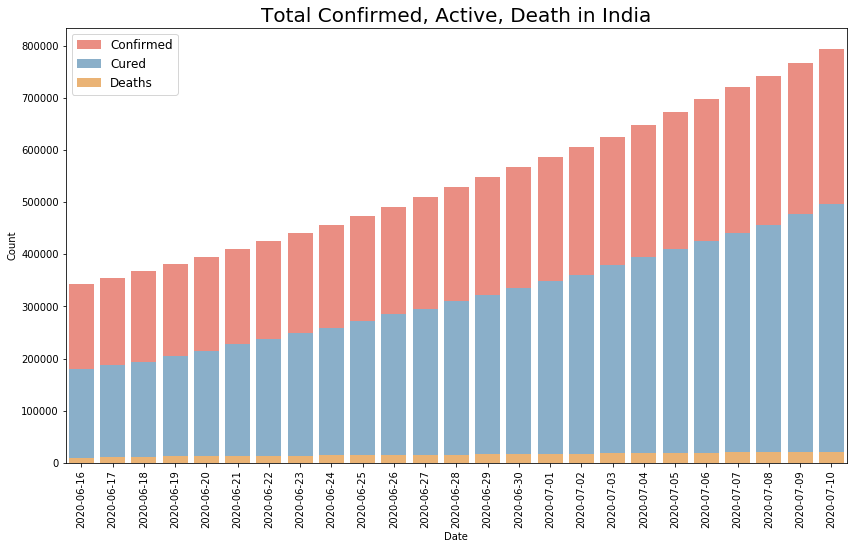

In [87]:
df2=df1.tail(25)
df2['Date'] = df2['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
plt.figure(figsize=(14,8))
sns.barplot(data=df2,x='Date',y='Confirmed',color=sns.color_palette('Set3')[3],label='Confirmed')
sns.barplot(data=df2,x='Date',y='Cured',color=sns.color_palette('Set3')[4],label='Cured')
sns.barplot(data=df2,x='Date',y='Deaths',color=sns.color_palette('Set3')[5],label='Deaths')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.title("Total Confirmed, Active, Death in India" , fontsize = 20)
plt.legend(frameon=True,fontsize=12);

## Test Labs

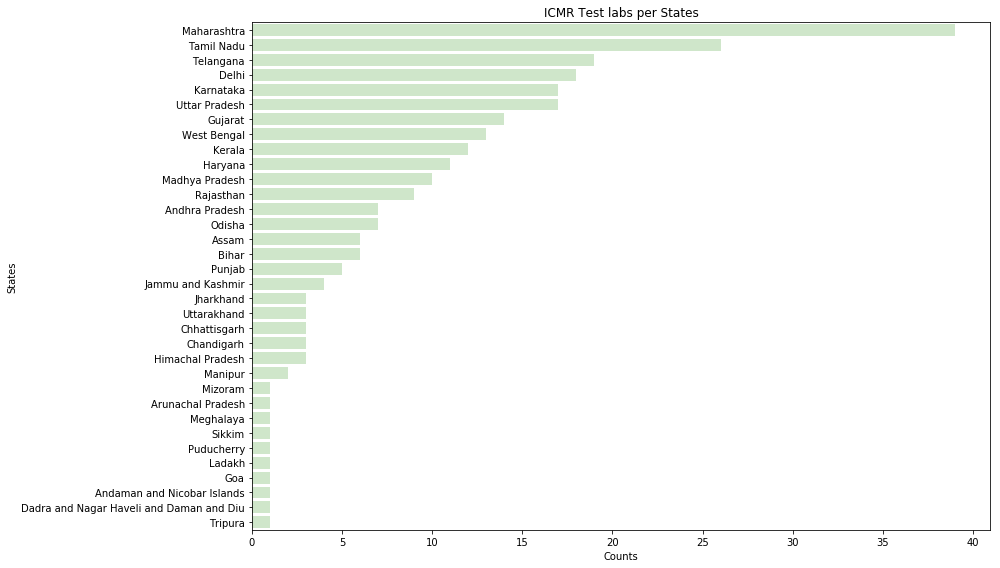

In [88]:
state=list(Labs['state'].value_counts().index)
count=list(Labs['state'].value_counts())
plt.figure(figsize=(14,8))
sns.barplot(x=count,y=state,color=sns.color_palette('Set3')[10])
plt.xlabel('Counts')
plt.ylabel('States')
plt.title('ICMR Test labs per States')
plt.tight_layout()